<a href="https://colab.research.google.com/github/HaaniaSiddiqui/Poet-Attribution-Using-Deep-Learning/blob/main/DL_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 316 : Introduction to Deep Learning
## Lab 10 : Binary Sentiment Classification
### Dr. Abdul Samad

# Setup

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical   

# Import Plotting Libararies
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data Preprocessing Libraries 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Models
from sklearn import svm  
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# Model Evaluation Libraries
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
from matplotlib.pyplot import imread, cm

# Overview

In this lab, you will create four models and train them using full word encoding on the [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb) . Following the embedding layer, these models employ various layers such as 'Flatten,' 'LSTM,' 'GRU,' and 'Conv1D.' You will compare their performance and determine which model is best for this specific dataset. Let's begin!

# [10 Points] Task 01 -  Download the Dataset
In this task, you will download the `plain_text` version of the `IMDB Reviews` dataset. 

In [ ]:
shayari = pd.read_csv("data3.txt", encoding='utf-16', header=None, sep=',', names=['text','labels'])
print(shayari['labels'].unique())
#xLabels=shayari['labels'].tolist()
xLabels=["AhmedFaraz","Iqbal","FaizAhmed","HaiderAli","JaunElia","Galib","Mir","MuneerNiazi","NazirAkbar","NidaFazli","ParveenShakir","Quteel","Siraj","Riyaz","Zafar"]
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
labeler = preprocessing.LabelEncoder()
shayari['labels'] = labeler.fit_transform(shayari["labels"])
numLabel=shayari['labels'].tolist()
print(shayari.head())
X_train, X_test, Y_train, Y_test = train_test_split(shayari['text'], shayari['labels'], test_size = 0.20, random_state = 0)

X_train = X_train.to_numpy()
Y_train=(Y_train.astype('int')).to_numpy()
Y_train=np.eye(15)[Y_train-1]
X_test = X_test.to_numpy()
Y_test=(Y_test.fillna(0).astype('int')).to_numpy()
Y_test=np.eye(15)[Y_test-1]

overallA=[]
overallL=[]
models=["Flatten","LSTM","GRU","Convolution"]

['احمد فراز' 'علامہ اقبال' 'فیض احمد فیض' 'حیدر علی آتش' 'جون ایلیا'
 'مرزا غالب' 'مير تقی میر' 'منیر نیازی' 'نظیر اکبر آبادی' 'ندا فاضلی'
 'پروین شاکر' 'قتیل شفائی' 'سراج اورنگ آبادی' 'ریاضؔ خیرآبادی' 'ظفر اقبال']
                                                text  labels
0  سنا ہے لوگ اسے آنکھ بھر کے دیکھتے ہیں ; سو اس ...       0
1  سنا ہے ربط ہے اس کو خراب حالوں سے ; سو اپنے آپ...       0
2  سنا ہے درد کی گاہک ہے چشم ناز اس کی ; سو ہم بھ...       0
3  سنا ہے اس کو بھی ہے شعر و شاعری سے شغف ; سو ہم...       0
4  سنا ہے بولے تو باتوں سے پھول جھڑتے ہیں ; یہ با...       0


# [10 Points] Task 02 -  Prepare the Dataset
After downloading the `plain_text` version, you will build the vocabulary from 
scratch and generate padded sequences using the `Tokenizer` class and `pad_sequences()` method

---
[Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)

In [ ]:
# Parameters
vocab_size = 500000
max_length = 17
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
# use Tokenizer Object to create tokenizer , where num_wrods is equal to vocab_size
# also use oov_tok for new words 
tokenizer = Tokenizer(num_words=vocab_size,
    oov_token=oov_tok
    )

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(X_train) # use fit_on_texts method on training sentences 
word_index = tokenizer.word_index

# Generate and pad the training sequences

sequences = tokenizer.texts_to_sequences(X_train)# generate sequences from the training data
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)# pad sequences with maxlen=max_length and keep truncating=trunc_type
print(padded[500], Y_test[0])
# Generate and pad the validation sequences
val_testing_sequences = tokenizer.texts_to_sequences(X_test) # generate sequences from the testing data
val_testing_padded = pad_sequences(val_testing_sequences, maxlen=max_length, truncating=trunc_type) # pad sequences with maxlen=max_length


# Generate and pad the validation sequences
#testing_sequences = tokenizer.texts_to_sequences(X_test) # generate sequences from the testing data
#testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type) # pad sequences with maxlen=max_length

[   0    0    0  291  189    7  646  906 1302    3  203   15   18  196
 2818   14  145] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Plot Utility

Before defining the models, define the function below to easily visualise the accuracy and loss history after training.

In [ ]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# [20 Points] Task 03 -  Flatten Layer

The first model uses the `Flatten` layer after the embedding layer. Its main advantage is that it is very quick to train. Examine the outcomes below.

*Note: Please keep in mind that you may see a different graph in the lectures. This is due to the fact that we changed the `BATCH SIZE` for training in order for subsequent models to train faster.*

---

[Embedding Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

In [ ]:
# Parameters
embedding_dim = 300
dense_dim = 256

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    # Add embedding layer with vocab_size, embedding_dim, input_length=max_length,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(15, activation='sigmoid')
])

model_flatten.summary()
# Set the training parameters

# Add code below
optimizer = keras.optimizers.Adam(lr=0.001)
model_flatten.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['categorical_accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 17, 300)           150000000 
                                                                 
 flatten_2 (Flatten)         (None, 5100)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               1305856   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 15)                975       
                                                                 
Total params: 151,323,279
Trainable params: 151,323,27

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
NUM_EPOCHS = 5
BATCH_SIZE = 32

# Train the model
#add code here

history_flatten = model_flatten.fit(padded, Y_train, batch_size = BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(val_testing_padded, Y_test)) # run the model on padded training sequences with validation data batch_size=BATCH_SIZE, epochs=NUM_EPOCHS
results = model_flatten.evaluate(val_testing_padded, Y_test)

Epoch 1/5
441/441 [==============================] - 37s 82ms/step - loss: 1.9450 - categorical_accuracy: 0.3768 - val_loss: 1.3725 - val_categorical_accuracy: 0.5636
Epoch 2/5
441/441 [==============================] - 36s 81ms/step - loss: 0.5302 - categorical_accuracy: 0.8401 - val_loss: 1.4244 - val_categorical_accuracy: 0.5818
Epoch 3/5
441/441 [==============================] - 36s 82ms/step - loss: 0.0559 - categorical_accuracy: 0.9864 - val_loss: 1.6196 - val_categorical_accuracy: 0.5906
Epoch 4/5
441/441 [==============================] - 36s 81ms/step - loss: 0.0078 - categorical_accuracy: 0.9993 - val_loss: 1.7604 - val_categorical_accuracy: 0.5917
Epoch 5/5
111/111 [==============================] - 1s 6ms/step - loss: 1.8423 - categorical_accuracy: 0.5875


[1.8423246145248413, 0.5874503254890442]
{'loss': [1.9450160264968872, 0.530178427696228, 0.05591117590665817, 0.00778082525357604, 0.003388691460713744], 'categorical_accuracy': [0.3768013119697571, 0.8400653004646301, 0.9864413738250732, 0.9992901086807251, 0.9995740652084351], 'val_loss': [1.372489094734192, 1.4243828058242798, 1.6196484565734863, 1.7603507041931152, 1.8423246145248413], 'val_categorical_accuracy': [0.5636002421379089, 0.581771731376648, 0.5905735492706299, 0.5917092561721802, 0.5874503254890442]}


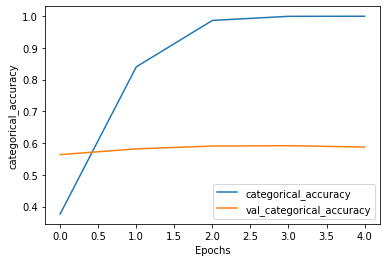

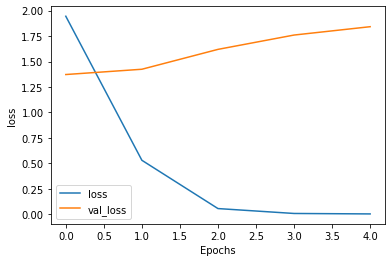

111/111 [==============================] - 0s 3ms/step
[[9.9280578e-01 3.3345355e-03 9.9996459e-01 ... 4.5411259e-02
  1.2246995e-02 2.6983058e-04]
 [3.5436995e-02 6.2165976e-01 4.4710454e-02 ... 8.9800072e-01
  5.0125018e-02 9.1437519e-01]
 [1.7735350e-03 7.3946750e-01 6.3626781e-02 ... 9.9454027e-01
  5.2496042e-02 4.7015317e-02]
 ...
 [9.9932754e-01 9.7618885e-02 5.6382064e-02 ... 2.9741041e-04
  9.9267238e-01 2.1142313e-02]
 [8.8246775e-01 3.3653238e-01 2.7435629e-03 ... 6.4166999e-01
  9.0299144e-02 5.1468503e-01]
 [2.2268968e-02 9.1721296e-01 9.9354857e-01 ... 1.3778254e-02
  1.7133245e-02 1.9253986e-02]]


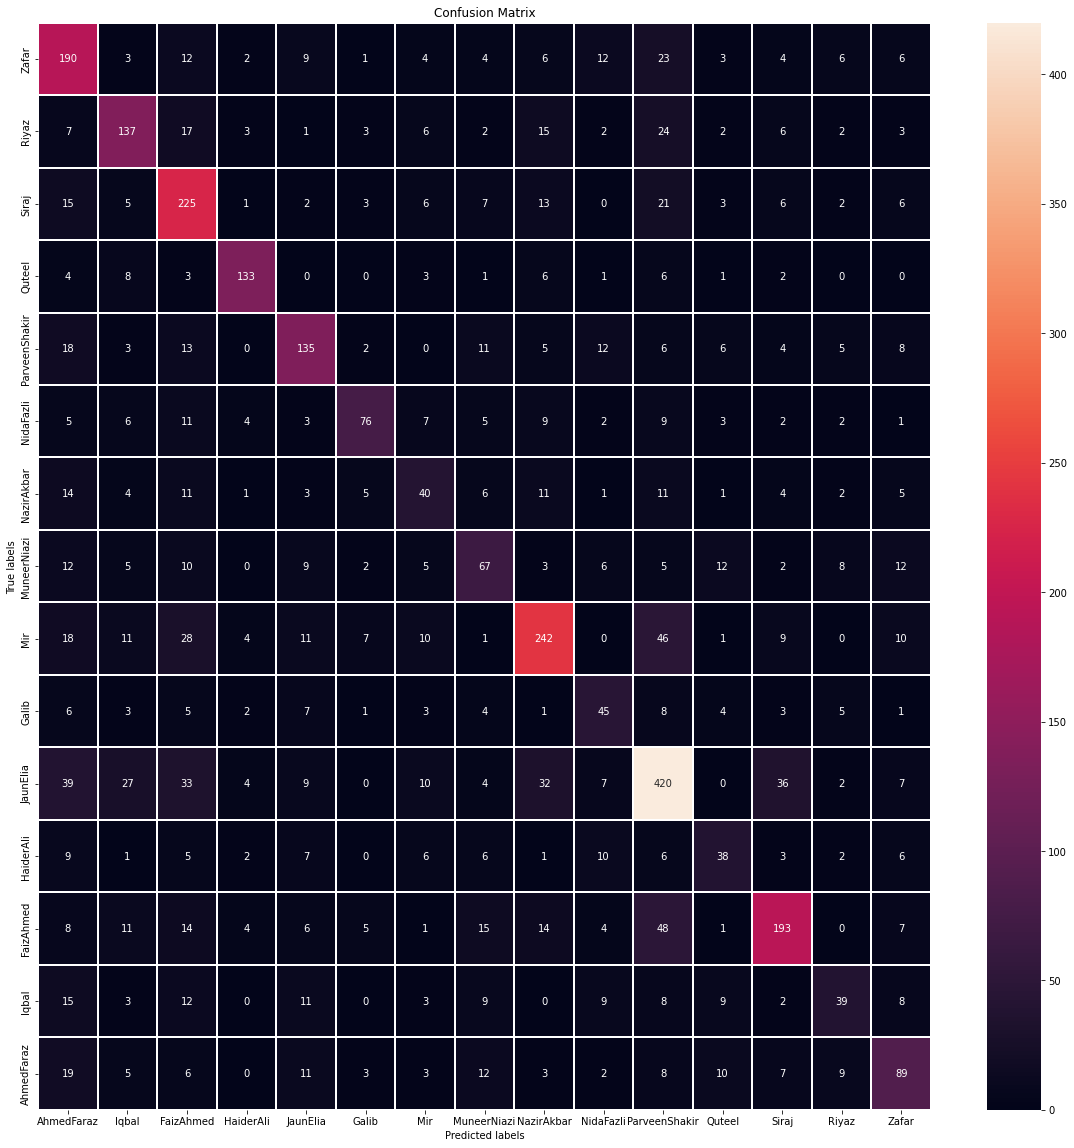

In [ ]:
# Plot the accuracy and loss history
print(results)
print(history_flatten.history)
overallA.append(history_flatten.history["categorical_accuracy"])
overallL.append(history_flatten.history["loss"])
#print(keras.metrics.accuracy(testing_padded, Y_test))
plot_graphs(history_flatten, 'categorical_accuracy')
plot_graphs(history_flatten, 'loss')

pred=model_flatten.predict(val_testing_padded)
print(pred)
y_pred=np.argmax(pred, axis=1)
y_test=np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)

fig,ax= plt.subplots(figsize=(20,20))
sns.heatmap(cm, linewidths=1,annot=True, fmt='g', ax=ax);


# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(xLabels); ax.yaxis.set_ticklabels(xLabels[::-1]);
# figure = f.get_figure()    
fig.savefig('svm_conf.png', dpi=400)



In [ ]:
def plot_multiclass_roc(name, fpr_tpr, auc_scores, figsize, linewidth, fontsize):

    plt.figure(figsize = (figsize*2, figsize))

    model_name = name.split('-')[0]
    fpr_dict, tpr_dict = fpr_tpr
    auc_scores_dict = auc_scores

    color = iter(cm.Dark2(np.linspace(0, 1, len(fpr_dict))))

    for key in auc_scores_dict:

        fpr = fpr_dict[key]
        tpr = tpr_dict[key]
        auc = auc_scores_dict[key]
        c = next(color)

        plt.plot(fpr, tpr, lw=linewidth, label = 'Class: {} (auc = {})'.format(key, auc), c=c)

    plt.plot([0, 1], [0, 1], color="navy", lw=linewidth, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=fontsize)
    plt.ylabel("True Positive Rate", fontsize=fontsize)
    plt.legend(loc="lower right", prop={'size':fontsize})

    plt.title('{} ROC Curve'.format(model_name), fontsize=fontsize+10)
    plt.savefig('{}_ROC.png'.format(model_name), bbox_inches='tight')
    plt.show()


100%|██████████| 15/15 [00:00<00:00, 989.27it/s]


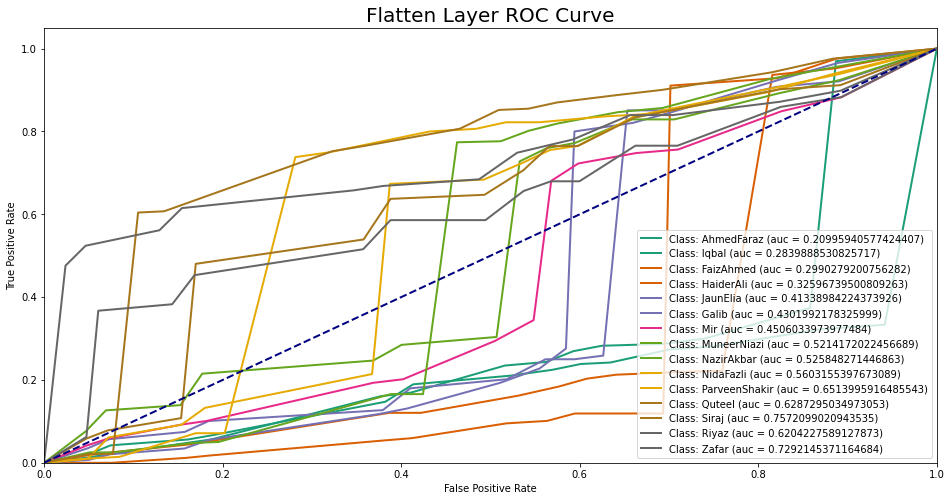

In [ ]:
from matplotlib.pyplot import imread, cm

# y_score=model_flatten.decision_function()
fpr_dict = dict()
tpr_dict = dict()
auc_scores_dict = dict()

for i in tqdm(range(len(xLabels))):
    label = xLabels[i]

    fpr_dict[label], tpr_dict[label], _ = roc_curve(y_test, y_pred, pos_label=i)
    auc_scores_dict[label] = auc(fpr_dict[label], tpr_dict[label])

plot_multiclass_roc("Flatten Layer", (fpr_dict, tpr_dict), auc_scores_dict, figsize=8, linewidth=2, fontsize=10)

# [20 Points] Task 04 -  LSTM

The second model uses an `LSTM` layer followed by the Embedding layer. This is slower to train but useful in applications where the order of the tokens is important.

---
[LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

[Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

In [ ]:
# Parameters
embedding_dim = 300
lstm_dim = 64
dense_dim = 128

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
     # Add embedding layer with vocab_size, embedding_dim, input_length=max_length,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=lstm_dim, activation='tanh')),#add an LSTM layer where the no of units is equal to lstm_dim),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(15, activation='sigmoid')
])

# Set the training parameters
# compile the above model for loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']
optimizer = keras.optimizers.Adam(lr=0.001)
model_lstm.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['categorical_accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 17, 300)           150000000 
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 15)                1935      
                                                                 
Total params: 150,205,327
Trainable params: 150,205,327
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
NUM_EPOCHS = 30
BATCH_SIZE = 64

# Train the model
history_lstm = model_lstm.fit(padded, Y_train, batch_size = BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(val_testing_padded, Y_test)) # run the model on padded training sequences with validation data batch_size=BATCH_SIZE, epochs=NUM_EPOCHS
results = model_lstm.evaluate(val_testing_padded, Y_test)

Epoch 1/30
221/221 [==============================] - 25s 90ms/step - loss: 2.0489 - categorical_accuracy: 0.3395 - val_loss: 1.6177 - val_categorical_accuracy: 0.4835
Epoch 2/30
221/221 [==============================] - 19s 85ms/step - loss: 1.1063 - categorical_accuracy: 0.6513 - val_loss: 1.4119 - val_categorical_accuracy: 0.5608
Epoch 3/30
221/221 [==============================] - 19s 85ms/step - loss: 0.6031 - categorical_accuracy: 0.8118 - val_loss: 1.4735 - val_categorical_accuracy: 0.5792
Epoch 4/30
221/221 [==============================] - 19s 85ms/step - loss: 0.3119 - categorical_accuracy: 0.9027 - val_loss: 1.6919 - val_categorical_accuracy: 0.5798
Epoch 5/30
221/221 [==============================] - 19s 85ms/step - loss: 0.1652 - categorical_accuracy: 0.9515 - val_loss: 2.0264 - val_categorical_accuracy: 0.5687
Epoch 6/30
221/221 [==============================] - 19s 85ms/step - loss: 0.0834 - categorical_accuracy: 0.9764 - val_loss: 2.3029 - val_categorical_accuracy:

[4.395396709442139, 0.5636002421379089]


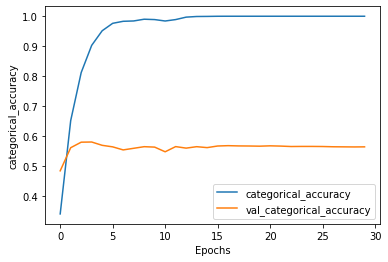

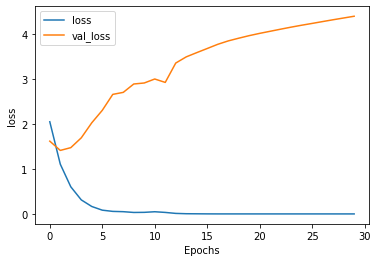

111/111 [==============================] - 1s 3ms/step


<Figure size 432x288 with 0 Axes>

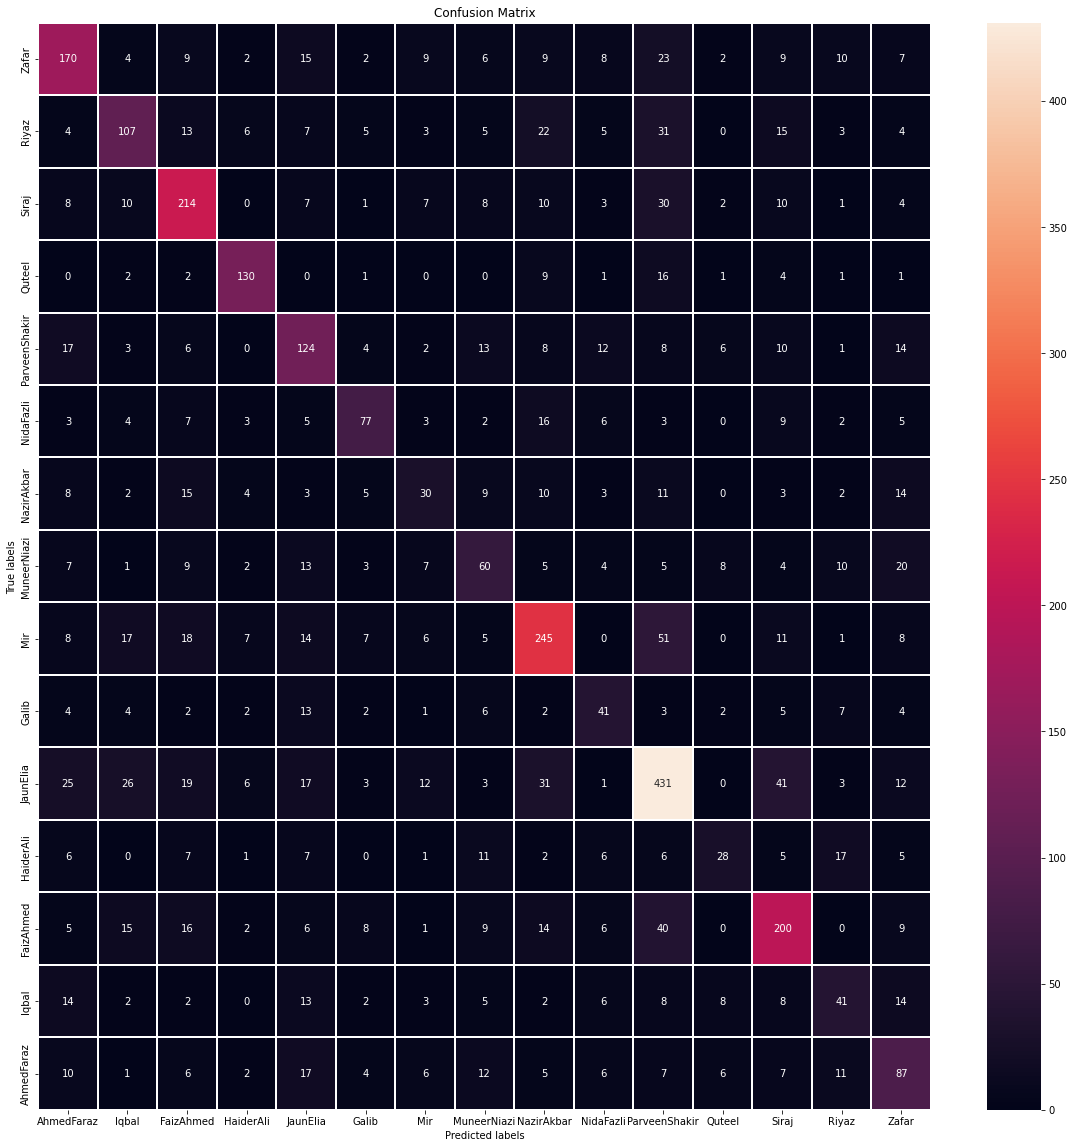

In [ ]:
# Plot the accuracy and loss history
print(results)
overallA.append(history_lstm.history['categorical_accuracy'])
overallL.append(history_lstm.history["loss"])
plot_graphs(history_lstm, 'categorical_accuracy')
plt.savefig('{}_acc.png'.format('lstm'))
plot_graphs(history_lstm, 'loss')
plt.savefig('{}_loss.png'.format('lstm'))

pred=model_lstm.predict(val_testing_padded)
y_pred=np.argmax(pred, axis=1)
y_test=np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)

fig,ax= plt.subplots(figsize=(20,20))
sns.heatmap(cm, linewidths=1,annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(xLabels); ax.yaxis.set_ticklabels(xLabels[::-1]);

fig.savefig('lstm_conf.png', dpi=400)

100%|██████████| 15/15 [00:00<00:00, 784.42it/s]


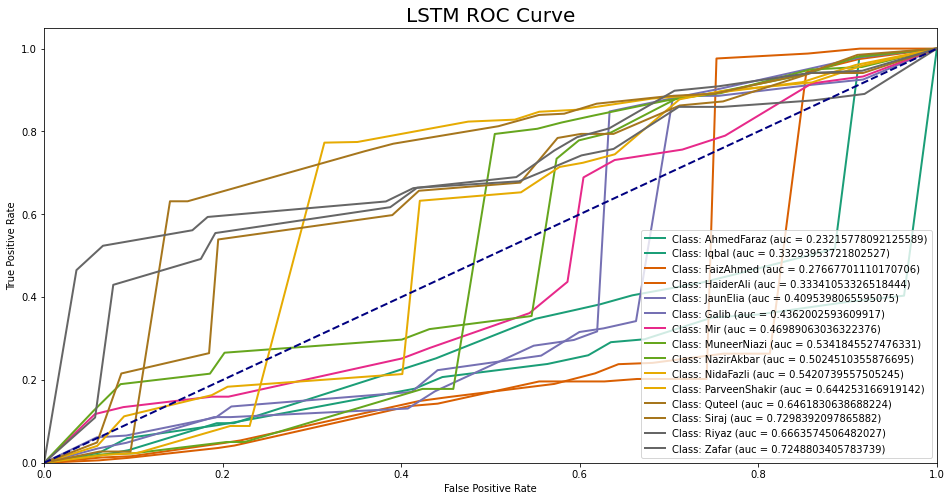

In [ ]:
from matplotlib.pyplot import imread, cm
# y_score=model_flatten.decision_function()
fpr_dict = dict()
tpr_dict = dict()
auc_scores_dict = dict()

for i in tqdm(range(len(xLabels))):
    label = xLabels[i]

    fpr_dict[label], tpr_dict[label], _ = roc_curve(y_test, y_pred, pos_label=i)
    auc_scores_dict[label] = auc(fpr_dict[label], tpr_dict[label])

plot_multiclass_roc("LSTM", (fpr_dict, tpr_dict), auc_scores_dict, figsize=8, linewidth=2, fontsize=10)

# [20 Points] Task 05 -  GRU
The third model uses an `GRU` followed by the embedding layer.
The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [ ]:
import tensorflow as tf


# Parameters
embedding_dim = 300
gru_dim = 128
dense_dim = 10

#define a model which used bidirection GRU, other details will be same as model_lstm

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=gru_dim)),#add an LSTM layer where the no of units is equal to lstm_dim),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(15, activation='sigmoid')
])

# Set the training parameters
# compile the above model for loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']
model_gru.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 17, 300)           150000000 
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              330240    
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 10)                2570      
                                                                 
 dense_12 (Dense)            (None, 15)                165       
                                                                 
Total params: 150,332,975
Trainable params: 150,332,975
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 64

# Train the model
history_gru =  model_gru.fit(padded, Y_train, batch_size = BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(val_testing_padded, Y_test)) # run the model on padded training sequences with validation data batch_size=BATCH_SIZE, epochs=NUM_EPOCHS

Epoch 1/20
221/221 [==============================] - 22s 90ms/step - loss: 2.3491 - accuracy: 0.2379 - val_loss: 2.0151 - val_accuracy: 0.3620
Epoch 2/20
221/221 [==============================] - 19s 85ms/step - loss: 1.5460 - accuracy: 0.5077 - val_loss: 1.6543 - val_accuracy: 0.5082
Epoch 3/20
221/221 [==============================] - 19s 85ms/step - loss: 0.9157 - accuracy: 0.7177 - val_loss: 1.5996 - val_accuracy: 0.5361
Epoch 4/20
221/221 [==============================] - 19s 85ms/step - loss: 0.5258 - accuracy: 0.8403 - val_loss: 1.8647 - val_accuracy: 0.5412
Epoch 5/20
221/221 [==============================] - 19s 85ms/step - loss: 0.3071 - accuracy: 0.9068 - val_loss: 2.0354 - val_accuracy: 0.5423
Epoch 6/20
221/221 [==============================] - 19s 85ms/step - loss: 0.1751 - accuracy: 0.9503 - val_loss: 2.4153 - val_accuracy: 0.5219
Epoch 7/20
221/221 [==============================] - 19s 85ms/step - loss: 0.0958 - accuracy: 0.9752 - val_loss: 2.7613 - val_accuracy:

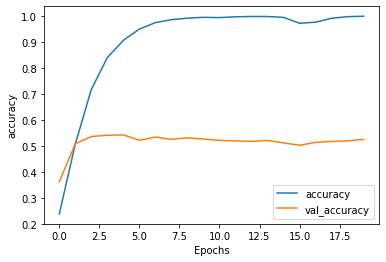

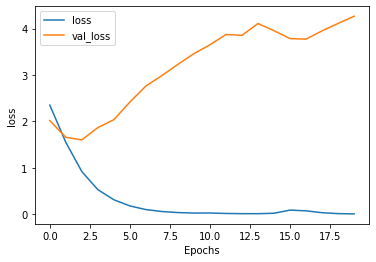

111/111 [==============================] - 1s 3ms/step


<Figure size 432x288 with 0 Axes>

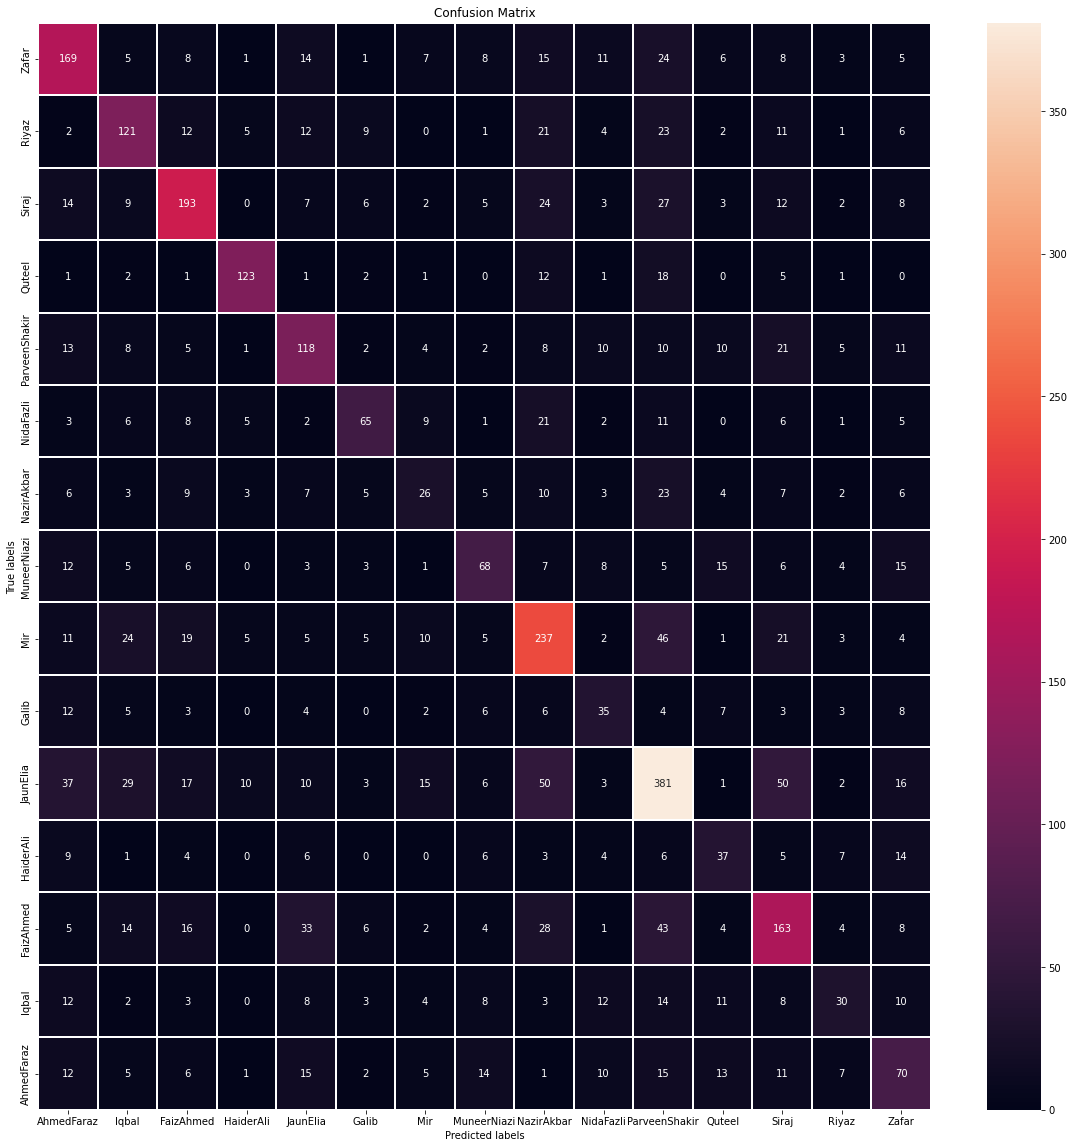

In [ ]:
# Plot the accuracy and loss history
overallA.append(history_gru.history["accuracy"])
overallL.append(history_gru.history["loss"])

plot_graphs(history_gru, 'accuracy')
plt.savefig('{}_acc.png'.format('gru'))
plot_graphs(history_gru, 'loss')
plt.savefig('{}_loss.png'.format('gru'))

pred=model_gru.predict(val_testing_padded)
y_pred=np.argmax(pred, axis=1)
y_test=np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)

fig,ax= plt.subplots(figsize=(20,20))
sns.heatmap(cm, linewidths=1,annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(xLabels); ax.yaxis.set_ticklabels(xLabels[::-1]);
fig.savefig('gru_conf.png', dpi=400)

100%|██████████| 15/15 [00:00<00:00, 733.63it/s]


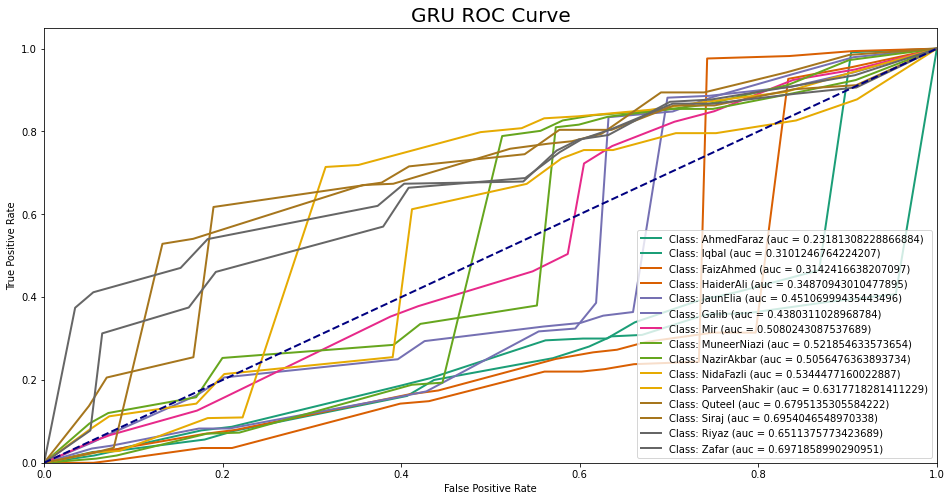

In [ ]:
from matplotlib.pyplot import imread, cm
# y_score=model_flatten.decision_function()
fpr_dict = dict()
tpr_dict = dict()
auc_scores_dict = dict()

for i in tqdm(range(len(xLabels))):
    label = xLabels[i]

    fpr_dict[label], tpr_dict[label], _ = roc_curve(y_test, y_pred, pos_label=i)
    auc_scores_dict[label] = auc(fpr_dict[label], tpr_dict[label])

plot_multiclass_roc("GRU", (fpr_dict, tpr_dict), auc_scores_dict, figsize=8, linewidth=2, fontsize=10)

# [20 Points] Task 06 -  Convolution

The fourth model uses a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

---
[Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/)

In [ ]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    # add embedding layer with vocab_size, embedding_dim, input_length=max_length,
    #add Conv1D with filters, kernel_size, activation='relu' mentioned above,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(15, activation='sigmoid')
])

# Set the training parameters
# compile the above model for loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']
model_conv.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 17, 16)            8000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 128)           10368     
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_17 (Dense)            (None, 6)                 774       
                                                                 
 dense_18 (Dense)            (None, 15)                105       
                                                                 
Total params: 8,011,247
Trainable params: 8,011,247
Non-trainable params: 0
____________________________________________

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 128

# Train the model
history_conv =   model_conv.fit(padded, Y_train, batch_size = BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(val_testing_padded, Y_test)) # run the model on padded training sequences with validation data batch_size=BATCH_SIZE, epochs=NUM_EPOCHS

Epoch 1/20
111/111 [==============================] - 5s 10ms/step - loss: 2.5783 - accuracy: 0.1253 - val_loss: 2.4211 - val_accuracy: 0.2183
Epoch 2/20
111/111 [==============================] - 1s 8ms/step - loss: 2.1867 - accuracy: 0.2820 - val_loss: 2.1025 - val_accuracy: 0.3012
Epoch 3/20
111/111 [==============================] - 1s 8ms/step - loss: 1.8153 - accuracy: 0.3769 - val_loss: 1.9835 - val_accuracy: 0.3512
Epoch 4/20
111/111 [==============================] - 1s 9ms/step - loss: 1.5271 - accuracy: 0.4859 - val_loss: 1.9740 - val_accuracy: 0.3725
Epoch 5/20
111/111 [==============================] - 1s 10ms/step - loss: 1.2983 - accuracy: 0.5683 - val_loss: 2.0757 - val_accuracy: 0.3799
Epoch 6/20
111/111 [==============================] - 1s 8ms/step - loss: 1.1294 - accuracy: 0.6334 - val_loss: 2.2119 - val_accuracy: 0.3782
Epoch 7/20
111/111 [==============================] - 1s 8ms/step - loss: 0.9977 - accuracy: 0.6808 - val_loss: 2.3677 - val_accuracy: 0.3864
Epoc

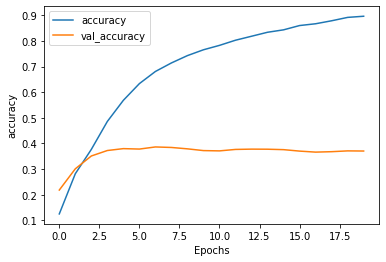

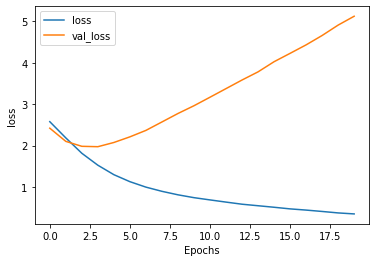

111/111 [==============================] - 0s 2ms/step


<Figure size 432x288 with 0 Axes>

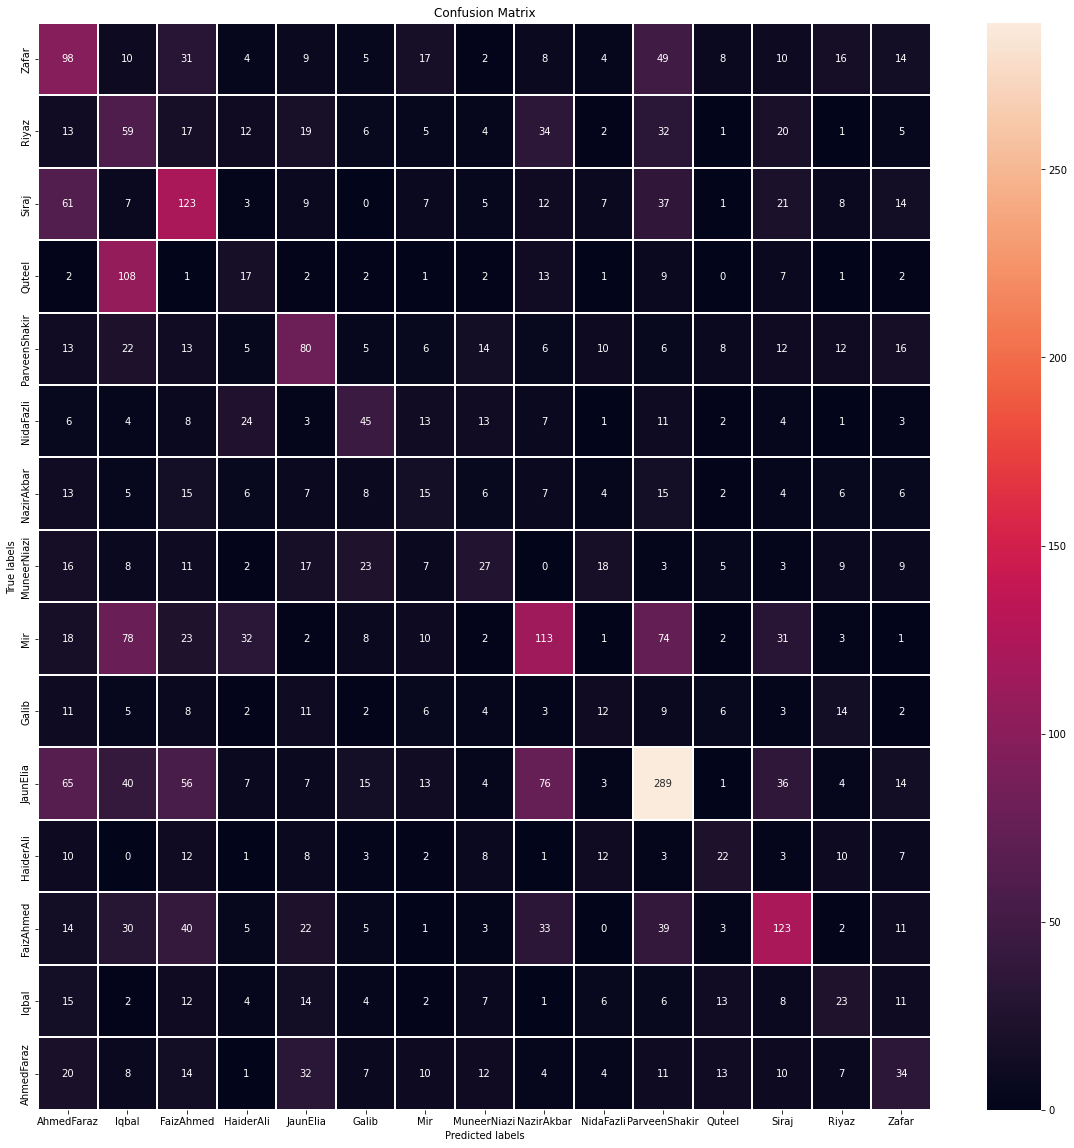

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plt.savefig('{}_acc.png'.format('conv'))
plot_graphs(history_conv, 'loss')
plt.savefig('{}_loss.png'.format('conv'))
overallA.append(history_conv.history["accuracy"])
overallL.append(history_conv.history["loss"])

pred=model_conv.predict(val_testing_padded)
y_pred=np.argmax(pred, axis=1)
y_test=np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)

fig,ax= plt.subplots(figsize=(20,20))
sns.heatmap(cm, linewidths=1,annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(xLabels); ax.yaxis.set_ticklabels(xLabels[::-1]);

fig.savefig('conv_conf.png', dpi=400)

100%|██████████| 15/15 [00:00<00:00, 1167.33it/s]


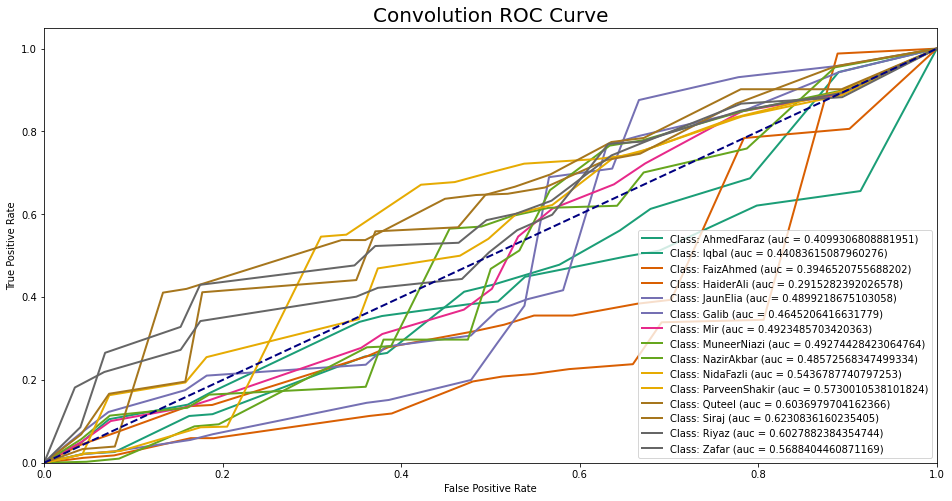

In [ ]:
from matplotlib.pyplot import imread, cm
# y_score=model_flatten.decision_function()
fpr_dict = dict()
tpr_dict = dict()
auc_scores_dict = dict()

for i in tqdm(range(len(xLabels))):
    label = xLabels[i]

    fpr_dict[label], tpr_dict[label], _ = roc_curve(y_test, y_pred, pos_label=i)
    auc_scores_dict[label] = auc(fpr_dict[label], tpr_dict[label])

plot_multiclass_roc("Convolution", (fpr_dict, tpr_dict), auc_scores_dict, figsize=8, linewidth=2, fontsize=10)

# Overall Comparison

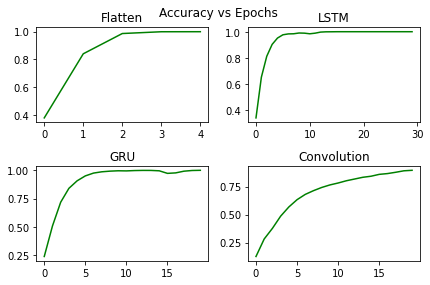

In [ ]:
figure, axis = plt.subplots(2, 2)
  
X1 = np.arange(0, 5)
X2 = np.arange(0, 30)
X3 = np.arange(0, 20)
X4 = np.arange(0, 20)
figure.subplots_adjust(hspace=0.4, top=0.6)
figure.suptitle("Accuracy vs Epochs")
# For Sine Function
axis[0, 0].plot(X1, overallA[0],color='green')
axis[0, 0].set_title("Flatten")
  
# For Cosine Function
axis[0, 1].plot(X2, overallA[1],color='green')
axis[0, 1].set_title("LSTM")
  
# For Tangent Function
axis[1, 0].plot(X3, overallA[2],color='green')
axis[1, 0].set_title("GRU")
  
# For Tanh Function
axis[1, 1].plot(X4, overallA[3],color='green')
axis[1, 1].set_title("Convolution")
# Combine all the operations and display



figure.tight_layout()
plt.show()


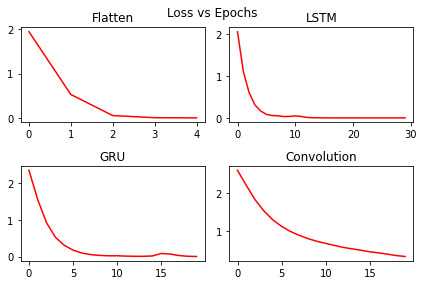

In [ ]:
figure, axis = plt.subplots(2, 2)
  
X1 = np.arange(0, 5)
X2 = np.arange(0, 30)
X3 = np.arange(0, 20)
X4 = np.arange(0, 20)

figure.subplots_adjust(hspace=0.4, top=0.6)
figure.suptitle("Loss vs Epochs")
# For Sine Function
axis[0, 0].plot(X1, overallL[0],color='red')
axis[0, 0].set_title("Flatten")
  
# For Cosine Function
axis[0, 1].plot(X2, overallL[1],color='red')
axis[0, 1].set_title("LSTM")
  
# For Tangent Function
axis[1, 0].plot(X3, overallL[2],color='red')
axis[1, 0].set_title("GRU")
  
# For Tanh Function
axis[1, 1].plot(X4, overallL[3],color='red')
axis[1, 1].set_title("Convolution")
# Combine all the operations and display
figure.tight_layout()
plt.show()